In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from pdf2image import convert_from_path
from PIL import Image
import matplotlib.pyplot as plt



In [2]:

class DocumentDataset(Dataset):
    def __init__(self, pdf_path, transform=None):
        self.pages = convert_from_path(pdf_path)
        self.transform = transform

    def __len__(self):
        return len(self.pages)

    def __getitem__(self, idx):
        image = self.pages[idx].convert('RGB')
        image = np.array(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image


In [3]:

class LayoutSegmentationModel(nn.Module):
    def __init__(self):
        super(LayoutSegmentationModel, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.encoder.fc = nn.Identity()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.encoder(x)
        features = features.view(features.size(0), 512, 1, 1)
        output = self.decoder(features)
        return output


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.6530312299728394
Epoch 2, Loss: 0.41653117537498474
Epoch 3, Loss: 0.21206682920455933
Epoch 4, Loss: 0.07676789909601212
Epoch 5, Loss: 0.019197380170226097
Model training complete.


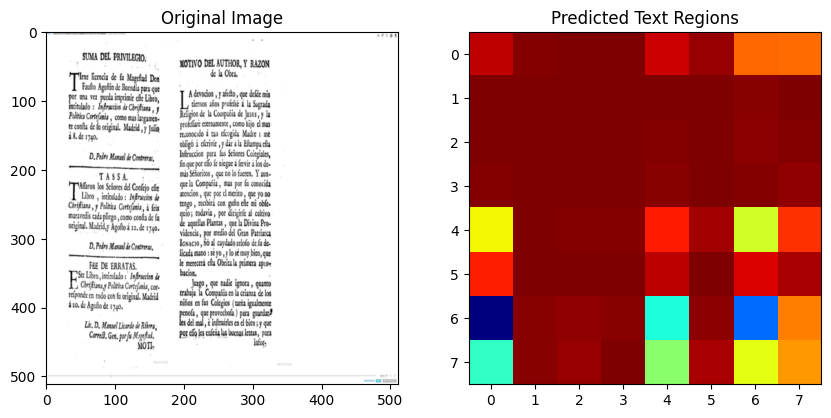

In [4]:


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

dataset = DocumentDataset('Buendia - Instruccion.pdf', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)



model = LayoutSegmentationModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(5):
    for images in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.ones_like(outputs))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

print("Model training complete.")

# Sample Inference
sample_image = next(iter(dataloader))
pred_mask = model(sample_image).detach().numpy()[0, 0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sample_image[0].permute(1,2,0), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap='jet')
plt.title('Predicted Text Regions')
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.5814302563667297
Epoch 2, Loss: 0.3235083222389221
Epoch 3, Loss: 0.1292436569929123
Epoch 4, Loss: 0.03673040494322777
Epoch 5, Loss: 0.0076937987469136715
Model training complete.


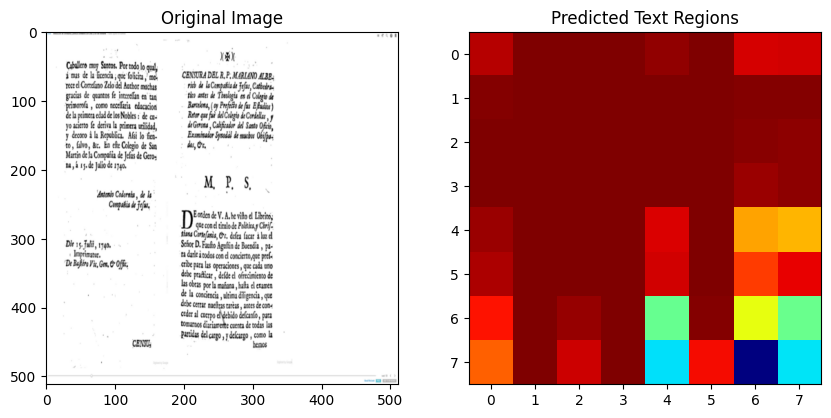

In [12]:


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

dataset = DocumentDataset('Buendia - Instruccion.pdf', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


model = LayoutSegmentationModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    for images in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.ones_like(outputs))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

print("Model training complete.")


sample_image = next(iter(dataloader))
pred_mask = model(sample_image).detach().numpy()[1,0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sample_image[0].permute(1,2,0), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap='jet')
plt.title('Predicted Text Regions')
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.812628448009491
Epoch 2, Loss: 0.4954063594341278
Epoch 3, Loss: 0.22765398025512695
Epoch 4, Loss: 0.07150491327047348
Epoch 5, Loss: 0.015753181651234627
Model training complete.


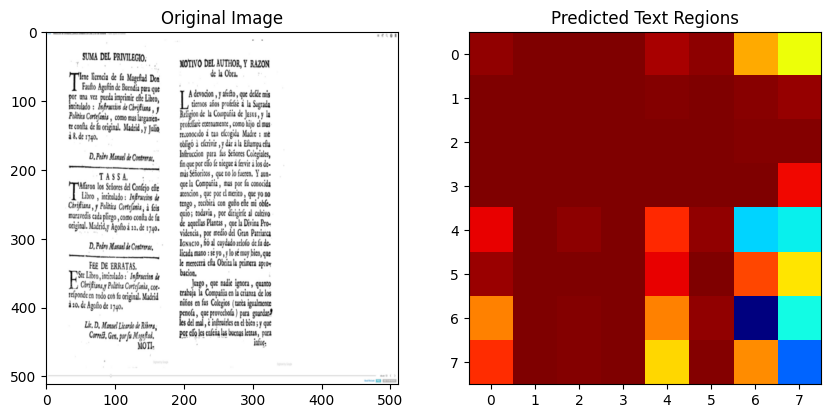

In [13]:


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

dataset = DocumentDataset('Buendia - Instruccion.pdf', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


model = LayoutSegmentationModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    for images in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.ones_like(outputs))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

print("Model training complete.")


sample_image = next(iter(dataloader))
pred_mask = model(sample_image).detach().numpy()[2,0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sample_image[0].permute(1,2,0), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap='jet')
plt.title('Predicted Text Regions')
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.7871171832084656
Epoch 2, Loss: 0.4772627055644989
Epoch 3, Loss: 0.21383120119571686
Epoch 4, Loss: 0.06939724087715149
Epoch 5, Loss: 0.019440585747361183
Model training complete.


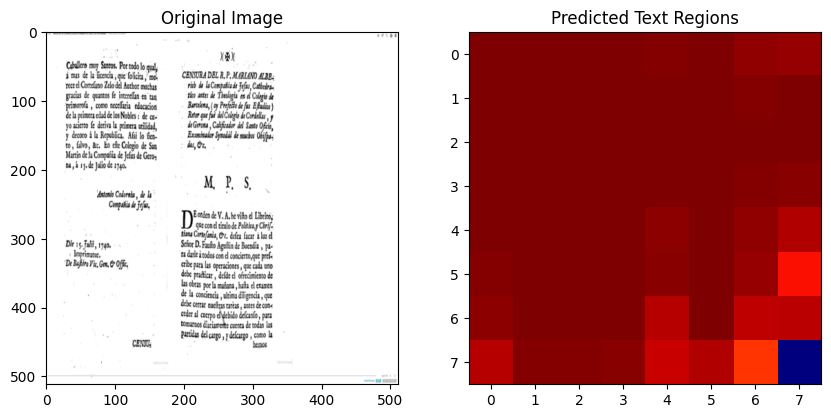

In [14]:


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

dataset = DocumentDataset('Buendia - Instruccion.pdf', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


model = LayoutSegmentationModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    for images in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.ones_like(outputs))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

print("Model training complete.")


sample_image = next(iter(dataloader))
pred_mask = model(sample_image).detach().numpy()[3,0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sample_image[0].permute(1,2,0), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap='jet')
plt.title('Predicted Text Regions')
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.6582940220832825
Epoch 2, Loss: 0.4329627752304077
Epoch 3, Loss: 0.219213604927063
Epoch 4, Loss: 0.07906494289636612
Epoch 5, Loss: 0.02091497741639614
Model training complete.


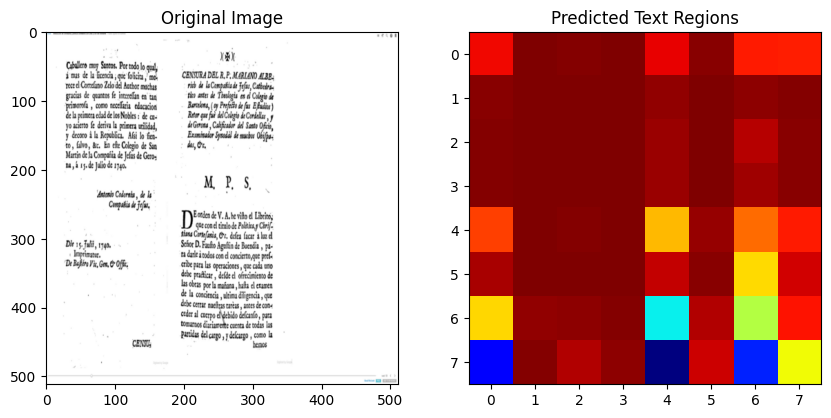

In [16]:


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

dataset = DocumentDataset('Buendia - Instruccion.pdf', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


model = LayoutSegmentationModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    for images in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.ones_like(outputs))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

print("Model training complete.")


sample_image = next(iter(dataloader))
pred_mask = model(sample_image).detach().numpy()[4,0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sample_image[0].permute(1,2,0), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap='jet')
plt.title('Predicted Text Regions')
plt.show()


In [ ]:


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

dataset = DocumentDataset('Buendia - Instruccion.pdf', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


model = LayoutSegmentationModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    for images in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.ones_like(outputs))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

print("Model training complete.")


sample_image = next(iter(dataloader))
pred_mask = model(sample_image).detach().numpy()[5,0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sample_image[0].permute(1,2,0), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap='jet')
plt.title('Predicted Text Regions')
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.6555767059326172
